<a href="https://colab.research.google.com/github/dittysan/machinelearningpractice/blob/main/Ch3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

In [9]:
mnist = fetch_openml('mnist_784', version = 1)
print(mnist.keys())

# dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

# (70000, 784) (70000,)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(70000, 784) (70000,)


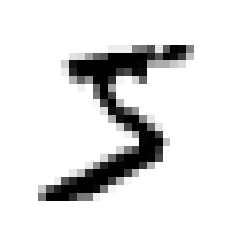

In [17]:
first_digit_im = X.to_numpy()[0].reshape(28,28)
plt.imshow(first_digit_im, cmap="binary")
plt.axis("off")
plt.show()

# cast as int
X = X.to_numpy()
y = y.to_numpy()

# create test, train
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [18]:
# binary classifier (whether 5 or not)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# # ---> SGD
sgd = SGDClassifier(random_state = 42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
# Performance Measures

# 1. Cross Validation
# --> splits into n folds, trains on one and tests against the rest
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits =3, shuffle = True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

# --> easier way to do it (although with less control)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv = 3, scoring = "accuracy")

0.9669
0.91625
0.96785


array([0.95035, 0.96035, 0.9604 ])

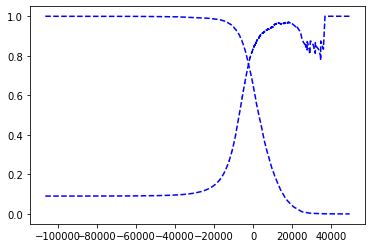

In [27]:
## in skewed datasets, accuracy is not as important (only 10% of images are 5s, so can be >90% accurate by always classifying as not 5)

# 2. Confusion Matrix

from sklearn.model_selection import cross_val_predict # performs K-fold, but returns predictions on each test fold instead of score
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

# each row is actual class, column is predicted class
# first row is negative, second is positive (top left: true negatives, bottom right: true positives)

## other derived metrics:
from sklearn.metrics import precision_score, recall_score, f1_score

## precision: tp / (tp + fp) --> accuracy of + preds
precision_score(y_train_5, y_train_pred)

## recall (sensitivity): tp / (tp + fn) --> ratio of + preds correctly detected by classifier
recall_score(y_train_5, y_train_pred)

## combine these into F1 score (harmonic mean), only high if both recall and precision are high
## 2 * (precision * recall) / (precision + recall)
f1_score(y_train_5, y_train_pred)

## precision-recall trade off: increasing precision is going to reduce the recall
## how to balance this?

from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method = "decision_function") # cross-val w decision function as output
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

## plotting: 
def plot_precisionrecall(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions [:-1], "b--", label= "Precision")
  plt.plot(thresholds, recalls [:-1], "b--", label= "Recall")

plot_precisionrecall(precisions, recalls, thresholds)
plt.show()

## can pick different model with different precisions by finding threshold at certain precision (argmax) 

<function matplotlib.pyplot.show>

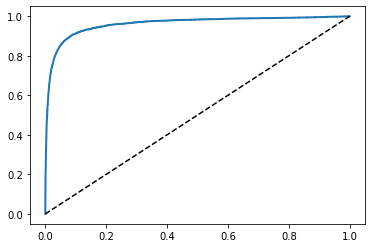

In [29]:
# 3. ROC (Receiver Operating Characteristic) [made a new section for this just to understand better since was never explained in ML classes]

## ratio of TPR (true positive rate, or recall) vs FRP (1 - specifcity)
## specificity is tn / (tn + fp)
## FPR = 1 - specificty = fp / (fp + tn)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0, 1], "k--")

plt.show

## perfect classifier will have AOC (area under the curve) = 1, purely random = 0.5
## very similar to precision / recall curve

In [38]:
# Multiclass Classification

## distinguish between more than just 2 different classes
## one-versus-all: classifier on each class, pick the one w the highest score
## one-versus-one: train classifier between each pair of classes --> this means need N*N-1 / 2 classifiers  ---> which class wins the most head to heads

## for problems that scale poorly o-v-o preferred, but o.w. o-v-a usually better
## scikit learn automatically does this based on alg.
## can force by deliberately importing one

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
ovo_sgd = OneVsOneClassifier(sgd)
ovr_sgd = OneVsRestClassifier(sgd)

test_digit = X[0]

ovo_sgd.fit(X_train, y_train)
ovo_sgd.predict([test_digit])
ovo_sgd.decision_function([test_digit])

ovr_sgd.fit(X_train, y_train)
ovr_sgd.predict([test_digit])
ovr_sgd.decision_function([test_digit])

array([[-13781.33922923, -24334.62190222, -11148.68966068,
         -3664.79262749, -20719.95525531,   2164.22030239,
        -31446.3628772 , -15088.01473606, -12954.44836362,
        -10802.51962293]])

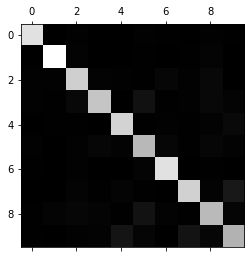

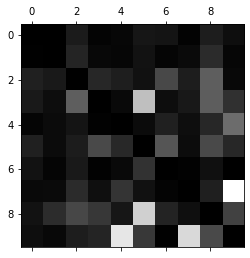

In [39]:
# Error Analysis

# plot confusion matrices with grayscale to analyze how model performed

y_train_pred = cross_val_predict(sgd, X_train, y_train, cv = 3)
cm = confusion_matrix(y_train, y_train_pred)

plt.matshow(cm, cmap = plt.cm.gray)
plt.show

# plot just the errors:
## need to divide by row sums to plot error rates, and clear the diagonal
row_sums = cm.sum(axis = 1, keepdims=True)
norm_cm = cm/row_sums
np.fill_diagonal(norm_cm, 0)
plt.matshow(norm_cm, cmap= plt.cm.gray)
plt.show()